In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dropout, Dense
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import os
import time
from tensorflow.keras import backend as K
import datetime
from tensorflow.keras import metrics
import tensorflow as tf

In [4]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

# Delete ","
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)

columns_to_clean = ['Open', 'High', 'Low', 'Close']
for col in columns_to_clean:
    train_data[col] = train_data[col].astype(str).str.replace(',', '').astype(float)
    test_data[col] = test_data[col].astype(str).str.replace(',', '').astype(float)

# Date
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

def normalize_data(data):
    data = np.array(data)
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data

train_scaled = normalize_data(train_data[['Open', 'High', 'Low', 'Close']])
test_scaled = normalize_data(test_data[['Open', 'High', 'Low', 'Close']])

# 训练集和测试集的不同滑动窗口
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        y.append(data[i, 3])  # 预测 'Close' 栏目
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled, 4)
X_test, y_test = create_dataset(test_scaled, 4)

split_ratio = 0.8
split_index = int(len(X_train) * split_ratio)
X_train_final = X_train[:split_index]
y_train_final = y_train[:split_index]
X_val = X_train[split_index:]
y_val = y_train[split_index:]

print(f"Train: {X_train_final.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (1003, 4, 4), Validation: (251, 4, 4), Test: (16, 4, 4)


In [5]:
lstm_parameters = {
    'LSTM_size': 50,
    'dropout': 0.2,
    'FC_size': 100,
    'optim': Adam,
    'lr': 0.001
}

gru_parameters = {
    'GRU_size': 50,
    'dropout': 0.2,
    'FC_size': 100,
    'optim': Adam,
    'lr': 0.001
}

rnn_parameters = {
    'RNN_size': 50,
    'dropout': 0.2,
    'FC_size': 100,
    'optim': Adam,
    'lr': 0.001
}

def build_LSTM(input_shape, parameters):
    model = Sequential()
    model.add(LSTM(units=lstm_parameters['LSTM_size'], 
                   input_shape=input_shape, 
                   unroll=True, stateful=False))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    
    optimizer = parameters["optim"](learning_rate=parameters["lr"])
    model.compile(loss='mse', optimizer=optimizer, metrics=[metrics.MeanAbsoluteError(), rmse, mda])
    return model

def build_GRU(input_shape, parameters):
    model = Sequential()
    model.add(GRU(units=gru_parameters['GRU_size'], 
                  input_shape=input_shape, 
                  unroll=True, stateful=False))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    
    optimizer = parameters["optim"](learning_rate=parameters["lr"])
    #model.compile(loss='mse', optimizer=optimizer, metrics=['mae', rmse, mda])
    model.compile(loss='mse', optimizer=optimizer, metrics=[metrics.MeanAbsoluteError(), rmse, mda])
    return model

def build_RNN(input_shape, parameters):
    model = Sequential()
    model.add(SimpleRNN(units=rnn_parameters['RNN_size'], 
                        input_shape=input_shape, 
                        unroll=True, stateful=False))
    model.add(Dropout(parameters['dropout']))
    model.add(Dense(parameters['FC_size'], activation='relu'))
    model.add(Dense(1))
    
    optimizer = parameters["optim"](learning_rate=parameters["lr"])
    #model.compile(loss='mse', optimizer=optimizer, metrics=['mae', rmse, mda])
    model.compile(loss='mse', optimizer=optimizer, metrics=[metrics.MeanAbsoluteError(), rmse, mda])
    return model

In [6]:
def custom_callbacks(callback_list, params, filepath=None):
    callbacks = []
    
    if 'mcp' in callback_list:
        mcp = ModelCheckpoint(filepath=filepath, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='min')
        callbacks.append(mcp)
        
    if 'csv_logger' in callback_list:
        timestamp = time.ctime().replace(" ", "_").replace(":", "_")
        csv_logger = CSVLogger(os.path.join('output', 
                                            f'training_log_{timestamp}.log'), 
                               append=True)
        callbacks.append(csv_logger)

    if 'es' in callback_list:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                           patience=params.get("earlystop", {}).get("patience", 10), 
                           min_delta=params.get("earlystop", {}).get("min_delta", 0.0001))
        callbacks.append(es)
        
    if 'reduce_lr' in callback_list:
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=params.get("reduce_lr", {}).get("factor", 0.5), 
                                      patience=params.get("reduce_lr", {}).get("patience", 3),
                                      min_delta=params.get("reduce_lr", {}).get("min_delta", 0.0001),
                                      verbose=0, mode='auto', cooldown=0, min_lr=0)
        callbacks.append(reduce_lr)

    return callbacks

callback_list = ['mcp', 'csv_logger', 'es', 'reduce_lr']

In [16]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def mda(y_true, y_pred, window=4):
    pred_diff = tf.sign(y_pred[window:] - y_pred[:-window])
    true_diff = tf.sign(y_true[window:] - y_true[:-window])
    return tf.reduce_mean(tf.cast(tf.equal(pred_diff, true_diff), tf.float32))

In [8]:
# LSTM
lstm_model = build_LSTM(input_shape=(None, X_train_final.shape[2]), parameters=lstm_parameters)
lstm_callbacks = custom_callbacks(callback_list, lstm_parameters, filepath='best_lstm_model.keras')
lstm_history = lstm_model.fit(X_train_final, y_train_final,
                               epochs=50,
                               batch_size=32,
                               validation_data=(X_val, y_val),
                               callbacks=lstm_callbacks,
                               verbose=1)

Epoch 1/50


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1064 - mda: 0.5006 - mean_absolute_error: 0.2441 - rmse: 0.3347
Epoch 1: val_loss improved from inf to 0.00065, saving model to best_lstm_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0991 - mda: 0.5007 - mean_absolute_error: 0.2350 - rmse: 0.3284 - val_loss: 6.4738e-04 - val_mda: 0.5437 - val_mean_absolute_error: 0.0206 - val_rmse: 0.0342 - learning_rate: 0.0010
Epoch 2/50
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - mda: 0.5053 - mean_absolute_error: 0.0820 - rmse: 0.2937 
Epoch 2: val_loss did not improve from 0.00065
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - mda: 0.5053 - mean_absolute_error: 0.0790 - rmse: 0.2989 - val_loss: 0.0096 - val_mda: 0.5412 - val_mean_absolute_error: 0.0967 - val_rmse: 0.1026 - learning_rate: 0.0010
Epoch 3/50
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - mda: 0.5028 - mean_absolute_error: 0.0346 - rmse: 0.3498 
Epoch 3: val_loss improved from 0.00065 to 0.

In [9]:
# GRU
gru_model = build_GRU(input_shape=(None, X_train_final.shape[2]), parameters=gru_parameters)
gru_callbacks = custom_callbacks(callback_list, gru_parameters, filepath='best_gru_model.keras')
gru_history = gru_model.fit(X_train_final, y_train_final,
                               epochs=50,
                               batch_size=32,
                               validation_data=(X_val, y_val),
                               callbacks=gru_callbacks,
                               verbose=1)

Epoch 1/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - mda: 0.5044 - mean_absolute_error: 0.1414 - rmse: 0.2944
Epoch 1: val_loss improved from inf to 0.01288, saving model to best_gru_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0320 - mda: 0.5041 - mean_absolute_error: 0.1311 - rmse: 0.2996 - val_loss: 0.0129 - val_mda: 0.5409 - val_mean_absolute_error: 0.1120 - val_rmse: 0.1169 - learning_rate: 0.0010
Epoch 2/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - mda: 0.5059 - mean_absolute_error: 0.0380 - rmse: 0.3491 
Epoch 2: val_loss improved from 0.01288 to 0.00311, saving model to best_gru_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - mda: 0.5062 - mean_absolute_error: 0.0377 - rmse: 0.3482 - val_loss: 0.0031 - val_mda: 0.5386 - val_mean_absolute_error: 0.0536 - val_rmse: 0.0639 - learning_rate: 0.0010
Epoch 3/50
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - mda: 0.5018 - mean_absolute_error: 0.0354 - rmse: 0.341

In [10]:
# RNN
rnn_model = build_RNN(input_shape=(None, X_train_final.shape[2]), parameters=rnn_parameters)
rnn_callbacks = custom_callbacks(callback_list, rnn_parameters, filepath='best_rnn_model.keras')
rnn_history = rnn_model.fit(X_train_final, y_train_final,
                               epochs=50,
                               batch_size=32,
                               validation_data=(X_val, y_val),
                               callbacks=gru_callbacks,
                               verbose=1)

Epoch 1/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0688 - mda: 0.5018 - mean_absolute_error: 0.1842 - rmse: 0.3613
Epoch 1: val_loss did not improve from 0.00026
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0655 - mda: 0.5019 - mean_absolute_error: 0.1786 - rmse: 0.3601 - val_loss: 0.0042 - val_mda: 0.5408 - val_mean_absolute_error: 0.0610 - val_rmse: 0.0693 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - mda: 0.5043 - mean_absolute_error: 0.0590 - rmse: 0.3346 
Epoch 2: val_loss did not improve from 0.00026
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - mda: 0.5042 - mean_absolute_error: 0.0590 - rmse: 0.3348 - val_loss: 0.0013 - val_mda: 0.5419 - val_mean_absolute_error: 0.0322 - val_rmse: 0.0452 - learning_rate: 0.0010
Epoch 3/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0052 - mda: 0.5026 - mean_absolute_error: 0.0603 - rmse: 0.4089
Epoch 3: val_loss did not improve from 0.00026
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [11]:
# 数据去归一化函数
def denormalize_data(normalized_data, min_vals, max_vals):
    return normalized_data * (max_vals - min_vals) + min_vals

def predict(model, X, batch_size):
    return model.predict(X, batch_size)

def calculate_mse(pred, true):
    return np.mean(np.square(pred - true))

def calculate_rmse(pred, true):
    return np.sqrt(np.mean(np.square(pred - true)))

def calculate_mda(pred, true, window=12):
    pred_diff = np.sign(pred[window:] - pred[:-window])
    true_diff = np.sign(true[window:] - true[:-window])
    return np.mean(pred_diff == true_diff)

def plot_predictions(true, pred, datetime, title=None, labels=None):
    plt.figure(figsize=(12, 6))
    plt.plot(datetime[-len(true):], true, label=labels[0], color='blue')  # 确保 datetime 的长度与 true 相同
    plt.plot(datetime[-len(pred):], pred, label=labels[1], color='red')  # 同理处理 pred
    plt.title(title)
    plt.legend()
    plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


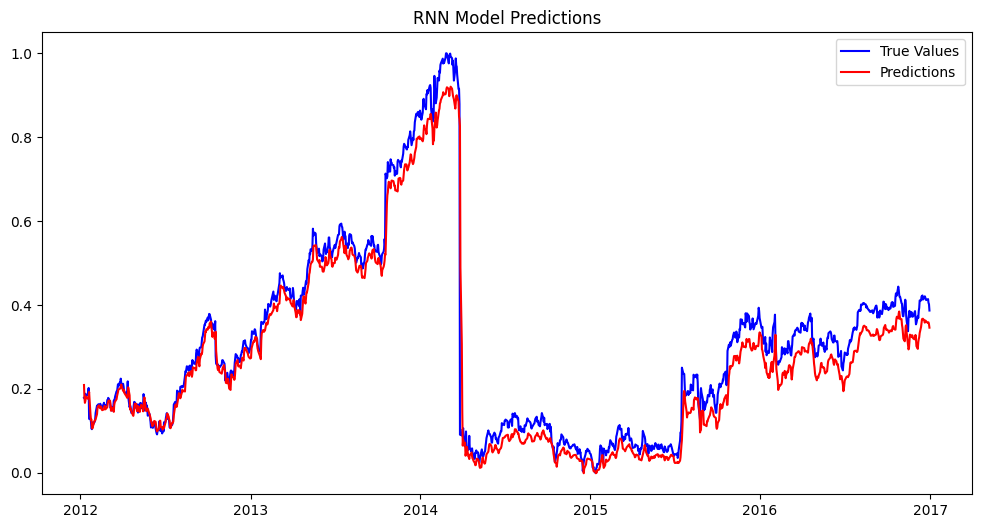

MSE: 0.0996829274851852, RMSE: 0.31572603232103813, MDA: 0.5147053866160496


In [12]:
# 获取训练集的最小值和最大值
min_vals = np.min(y_train, axis=0)
max_vals = np.max(y_train, axis=0)

# 用模型预测并处理数据
predictions = predict(rnn_model, X_train, batch_size=32)
predictions_org = denormalize_data(predictions, min_vals, max_vals)
true_org = denormalize_data(y_train, min_vals, max_vals)

# 计算MSE, RMSE和MDA
mse = calculate_mse(predictions_org, true_org)
rmse = calculate_rmse(predictions_org, true_org)
mda = calculate_mda(predictions_org, true_org)

# 绘制预测结果
labels = ['True Values', 'Predictions']
plot_predictions(true_org, predictions_org, train_data.index, title="RNN Model Predictions", labels=labels)

print(f'MSE: {mse}, RMSE: {rmse}, MDA: {mda}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


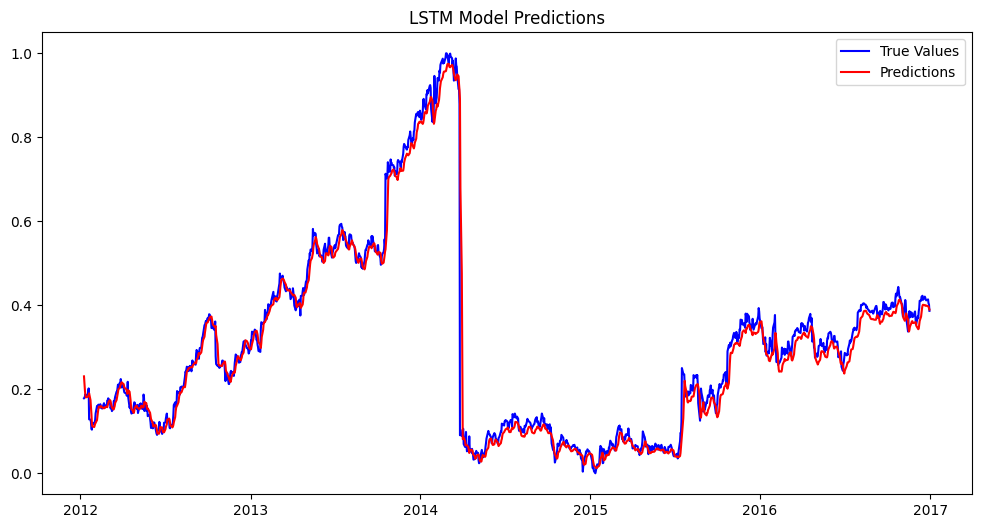

MSE: 0.10167472296969281, RMSE: 0.31886474086937366, MDA: 0.5164920223731397


In [13]:
# 获取训练集的最小值和最大值
min_vals = np.min(y_train, axis=0)
max_vals = np.max(y_train, axis=0)

# 用模型预测并处理数据
predictions = predict(lstm_model, X_train, batch_size=32)
predictions_org = denormalize_data(predictions, min_vals, max_vals)
true_org = denormalize_data(y_train, min_vals, max_vals)

# 计算MSE, RMSE和MDA
mse = calculate_mse(predictions_org, true_org)
rmse = calculate_rmse(predictions_org, true_org)
mda = calculate_mda(predictions_org, true_org)

# 绘制预测结果
labels = ['True Values', 'Predictions']
plot_predictions(true_org, predictions_org, train_data.index, title="LSTM Model Predictions", labels=labels)

print(f'MSE: {mse}, RMSE: {rmse}, MDA: {mda}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


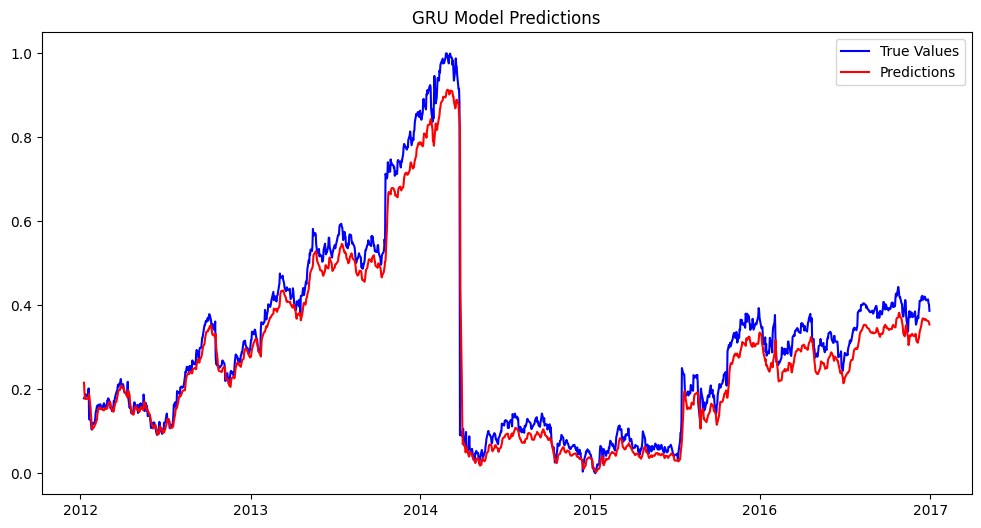

MSE: 0.09743713611185302, RMSE: 0.3121492209054077, MDA: 0.5151176871753781


In [14]:
# 获取训练集的最小值和最大值
min_vals = np.min(y_train, axis=0)
max_vals = np.max(y_train, axis=0)

# 用模型预测并处理数据
predictions = predict(gru_model, X_train, batch_size=32)
predictions_org = denormalize_data(predictions, min_vals, max_vals)
true_org = denormalize_data(y_train, min_vals, max_vals)

# 计算MSE, RMSE和MDA
mse = calculate_mse(predictions_org, true_org)
rmse = calculate_rmse(predictions_org, true_org)
mda = calculate_mda(predictions_org, true_org)

# 绘制预测结果
labels = ['True Values', 'Predictions']
plot_predictions(true_org, predictions_org, train_data.index, title="GRU Model Predictions", labels=labels)

print(f'MSE: {mse}, RMSE: {rmse}, MDA: {mda}')

In [17]:
def rnn_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    rnn_best_score = float('inf')
    rnn_best_params = {}
    RNN_sizes = [50, 100, 150]
    dropouts = [0.2, 0.3, 0.5]
    FC_sizes = [100, 150]
    lrs = [0.001, 0.01, 0.1]
    optimizers = [Adam, RMSprop, SGD]

    for RNN_size in RNN_sizes:
        for dropout in dropouts:
            for FC_size in FC_sizes:
                for lr in lrs:
                    for optim in optimizers:
                        parameters = {
                            'RNN_size': RNN_size,
                            'dropout': dropout,
                            'FC_size': FC_size,
                            'lr': lr,
                            'optim': optim
                        }
                        
                        print(f'RNN_size: {RNN_size}, dropout: {dropout}, FC_size: {FC_size}, lr: {lr}, optim: {optim}')
                        rnn_model = build_RNN(input_shape=(None, X_train.shape[2]), parameters=parameters)
                        rnn_callbacks = custom_callbacks(callback_list, parameters, filepath='best_rnn_model.keras')
                        rnn_history = rnn_model.fit(X_train, y_train,
                                                     epochs=10,
                                                     batch_size=32,
                                                     validation_data=(X_val, y_val),
                                                     callbacks=rnn_callbacks,
                                                     verbose=0)

                        val_loss = rnn_model.evaluate(X_val, y_val, verbose=0)[0]
                        if val_loss < rnn_best_score:
                            rnn_best_score = val_loss
                            rnn_best_params = {
                                'RNN_size': RNN_size,
                                'dropout': dropout,
                                'FC_size': FC_size,
                                'lr': lr,
                                'optim': optim.__name__
                            }
    return rnn_best_params, rnn_best_score

rnn_best_params, rnn_best_score = rnn_hyperparameter_tuning(X_train_final, y_train_final, X_val, y_val)

RNN_size: 50, dropout: 0.2, FC_size: 100, lr: 0.001, optim: <class 'keras.src.optimizers.adam.Adam'>

Epoch 1: val_loss improved from inf to 0.00316, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.00316 to 0.00048, saving model to best_rnn_model.keras

Epoch 3: val_loss did not improve from 0.00048

Epoch 4: val_loss did not improve from 0.00048

Epoch 5: val_loss did not improve from 0.00048

Epoch 6: val_loss did not improve from 0.00048

Epoch 7: val_loss did not improve from 0.00048

Epoch 8: val_loss did not improve from 0.00048

Epoch 9: val_loss improved from 0.00048 to 0.00042, saving model to best_rnn_model.keras

Epoch 10: val_loss improved from 0.00042 to 0.00034, saving model to best_rnn_model.keras
RNN_size: 50, dropout: 0.2, FC_size: 100, lr: 0.001, optim: <class 'keras.src.optimizers.rmsprop.RMSprop'>

Epoch 1: val_loss improved from inf to 0.05621, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.05621 to 0.00290, saving m

In [18]:
def gru_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    gru_best_score = float('inf')
    gru_best_params = {}
    GRU_sizes = [50, 100, 150]
    dropouts = [0.2, 0.3, 0.5]
    FC_sizes = [100, 150]
    lrs = [0.001, 0.01, 0.1]
    optimizers = [Adam, RMSprop, SGD]

    for GRU_size in GRU_sizes:
        for dropout in dropouts:
            for FC_size in FC_sizes:
                for lr in lrs:
                    for optim in optimizers:
                        parameters = {
                            'GRU_size': GRU_size,
                            'dropout': dropout,
                            'FC_size': FC_size,
                            'lr': lr,
                            'optim': optim
                        }
                        
                        print(f'GRU_size: {GRU_size}, dropout: {dropout}, FC_size: {FC_size}, lr: {lr}, optim: {optim}')
                        gru_model = build_GRU(input_shape=(None, X_train.shape[2]), parameters=parameters)
                        gru_callbacks = custom_callbacks(callback_list, parameters, filepath='best_gru_model.keras')
                        gru_history = gru_model.fit(X_train, y_train,
                                                     epochs=10,
                                                     batch_size=32,
                                                     validation_data=(X_val, y_val),
                                                     callbacks=rnn_callbacks,
                                                     verbose=0)

                        val_loss = gru_model.evaluate(X_val, y_val, verbose=0)[0]
                        if val_loss < gru_best_score:
                            gru_best_score = val_loss
                            gru_best_params = {
                                'GRU_size': GRU_size,
                                'dropout': dropout,
                                'FC_size': FC_size,
                                'lr': lr,
                                'optim': optim.__name__
                            }
    return gru_best_params, gru_best_score

gru_best_params, gru_best_score = gru_hyperparameter_tuning(X_train_final, y_train_final, X_val, y_val)

GRU_size: 50, dropout: 0.2, FC_size: 100, lr: 0.001, optim: <class 'keras.src.optimizers.adam.Adam'>

Epoch 1: val_loss improved from inf to 0.00057, saving model to best_rnn_model.keras

Epoch 2: val_loss improved from 0.00057 to 0.00055, saving model to best_rnn_model.keras

Epoch 3: val_loss did not improve from 0.00055

Epoch 4: val_loss did not improve from 0.00055

Epoch 5: val_loss improved from 0.00055 to 0.00028, saving model to best_rnn_model.keras

Epoch 6: val_loss did not improve from 0.00028

Epoch 7: val_loss did not improve from 0.00028

Epoch 8: val_loss improved from 0.00028 to 0.00026, saving model to best_rnn_model.keras

Epoch 9: val_loss did not improve from 0.00026

Epoch 10: val_loss improved from 0.00026 to 0.00025, saving model to best_rnn_model.keras
GRU_size: 50, dropout: 0.2, FC_size: 100, lr: 0.001, optim: <class 'keras.src.optimizers.rmsprop.RMSprop'>

Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3:

In [19]:
def lstm_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    lstm_best_score = float('inf')
    letm_best_params = {}
    LSTM_sizes = [50, 100, 150]
    dropouts = [0.2, 0.3, 0.5]
    FC_sizes = [100, 150]
    lrs = [0.001, 0.01, 0.1]
    optimizers = [Adam, RMSprop, SGD]

    for LSTM_size in LSTM_sizes:
        for dropout in dropouts:
            for FC_size in FC_sizes:
                for lr in lrs:
                    for optim in optimizers:
                        parameters = {
                            'LSTM_size': LSTM_size,
                            'dropout': dropout,
                            'FC_size': FC_size,
                            'lr': lr,
                            'optim': optim
                        }
                        
                        print(f'LSTM_size: {LSTM_size}, dropout: {dropout}, FC_size: {FC_size}, lr: {lr}, optim: {optim}')
                        lstm_model = build_LSTM(input_shape=(None, X_train.shape[2]), parameters=parameters)
                        lstm_callbacks = custom_callbacks(callback_list, parameters, filepath='best_lstm_model.keras')
                        lstm_history = lstm_model.fit(X_train, y_train,
                                                     epochs=10,
                                                     batch_size=32,
                                                     validation_data=(X_val, y_val),
                                                     callbacks=rnn_callbacks,
                                                     verbose=0)

                        val_loss = lstm_model.evaluate(X_val, y_val, verbose=0)[0]
                        if val_loss < lstm_best_score:
                            lstm_best_score = val_loss
                            lstm_best_params = {
                                'LSTM_size': LSTM_size,
                                'dropout': dropout,
                                'FC_size': FC_size,
                                'lr': lr,
                                'optim': optim.__name__
                            }
    return lstm_best_params, lstm_best_score

lstm_best_params, lstm_best_score = lstm_hyperparameter_tuning(X_train_final, y_train_final, X_val, y_val)

LSTM_size: 50, dropout: 0.2, FC_size: 100, lr: 0.001, optim: <class 'keras.src.optimizers.adam.Adam'>

Epoch 1: val_loss did not improve from 0.00019

Epoch 2: val_loss did not improve from 0.00019

Epoch 3: val_loss did not improve from 0.00019

Epoch 4: val_loss did not improve from 0.00019

Epoch 5: val_loss did not improve from 0.00019

Epoch 6: val_loss did not improve from 0.00019

Epoch 7: val_loss did not improve from 0.00019

Epoch 8: val_loss did not improve from 0.00019

Epoch 9: val_loss did not improve from 0.00019

Epoch 10: val_loss did not improve from 0.00019
LSTM_size: 50, dropout: 0.2, FC_size: 100, lr: 0.001, optim: <class 'keras.src.optimizers.rmsprop.RMSprop'>

Epoch 1: val_loss did not improve from 0.00019

Epoch 2: val_loss did not improve from 0.00019

Epoch 3: val_loss did not improve from 0.00019

Epoch 4: val_loss did not improve from 0.00019

Epoch 5: val_loss did not improve from 0.00019

Epoch 6: val_loss did not improve from 0.00019

Epoch 7: val_loss di

In [20]:
print(f"Best parameters: {rnn_best_params}")
print(f"Best parameters: {gru_best_params}")
print(f"Best parameters: {lstm_best_params}")

Best parameters: {'RNN_size': 50, 'dropout': 0.2, 'FC_size': 150, 'lr': 0.01, 'optim': 'Adam'}
Best parameters: {'GRU_size': 150, 'dropout': 0.2, 'FC_size': 150, 'lr': 0.001, 'optim': 'RMSprop'}
Best parameters: {'LSTM_size': 100, 'dropout': 0.3, 'FC_size': 150, 'lr': 0.01, 'optim': 'Adam'}


In [21]:
optimizer_mapping = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop
}

if isinstance(lstm_best_params["optim"], str):
    lstm_best_params["optim"] = optimizer_mapping[lstm_best_params["optim"]]

lstm_final_model = build_LSTM(input_shape=(None, X_train_final.shape[2]), parameters=lstm_best_params)
lstm_final_callbacks = custom_callbacks(callback_list, lstm_best_params, filepath='lstm_final_model.keras')

lstm_final_history = lstm_final_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=lstm_final_callbacks,
    verbose=1
)

lstm_test_loss, lstm_test_mae, lstm_test_rmse, lstm_test_mda = lstm_final_model.evaluate(X_test, y_test, verbose=1)
print("\nFinal Model Evaluation on Test Set:")
print(f"Loss (MSE): {lstm_test_loss}")
print(f"MAE: {lstm_test_mae}")
print(f"RMSE: {lstm_test_rmse}")
print(f"MDA: {lstm_test_mda}")

Epoch 1/50
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0468 - mda: 0.5005 - mean_absolute_error: 0.1431 - rmse: 0.3268
Epoch 1: val_loss improved from inf to 0.00603, saving model to lstm_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0380 - mda: 0.5015 - mean_absolute_error: 0.1251 - rmse: 0.3304 - val_loss: 0.0060 - val_mda: 0.5380 - val_mean_absolute_error: 0.0760 - val_rmse: 0.0835 - learning_rate: 0.0100
Epoch 2/50
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mda: 0.5072 - mean_absolute_error: 0.0413 - rmse: 0.3388 
Epoch 2: val_loss improved from 0.00603 to 0.00419, saving model to lstm_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - mda: 0.5065 - mean_absolute_error: 0.0406 - rmse: 0.3387 - val_loss: 0.0042 - val_mda: 0.5380 - val_mean_absolute_error: 0.0628 - val_rmse: 0.0724 - learning_rate: 0.0100
Epoch 3/50
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - mda: 0.5051 - mean_absolute_error: 0.0323 - rmse: 0

In [22]:
optimizer_mapping = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop
}

if isinstance(gru_best_params["optim"], str):
    gru_best_params["optim"] = optimizer_mapping[gru_best_params["optim"]]

gru_final_model = build_LSTM(input_shape=(None, X_train_final.shape[2]), parameters=gru_best_params)
gru_final_callbacks = custom_callbacks(callback_list, gru_best_params, filepath='gru_final_model.keras')

gru_final_history = gru_final_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=gru_final_callbacks,
    verbose=1
)

gru_test_loss, gru_test_mae, gru_test_rmse, gru_test_mda = gru_final_model.evaluate(X_test, y_test, verbose=1)
print("\nFinal Model Evaluation on Test Set:")
print(f"Loss (MSE): {gru_test_loss}")
print(f"MAE: {gru_test_mae}")
print(f"RMSE: {gru_test_rmse}")
print(f"MDA: {gru_test_mda}")

Epoch 1/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0699 - mda: 0.5006 - mean_absolute_error: 0.1911 - rmse: 0.3012
Epoch 1: val_loss improved from inf to 0.00131, saving model to gru_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0669 - mda: 0.5011 - mean_absolute_error: 0.1860 - rmse: 0.3001 - val_loss: 0.0013 - val_mda: 0.5434 - val_mean_absolute_error: 0.0325 - val_rmse: 0.0457 - learning_rate: 0.0010
Epoch 2/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - mda: 0.5045 - mean_absolute_error: 0.0494 - rmse: 0.3288 
Epoch 2: val_loss did not improve from 0.00131
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - mda: 0.5046 - mean_absolute_error: 0.0491 - rmse: 0.3297 - val_loss: 0.0036 - val_mda: 0.5434 - val_mean_absolute_error: 0.0574 - val_rmse: 0.0688 - learning_rate: 0.0010
Epoch 3/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mda: 0.5047 - mean_absolute_error: 0.0392 - rmse: 0.3351 
Epoch 3: val_loss did not improve from

In [23]:
optimizer_mapping = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop
}

if isinstance(rnn_best_params["optim"], str):
    rnn_best_params["optim"] = optimizer_mapping[rnn_best_params["optim"]]

rnn_final_model = build_RNN(input_shape=(None, X_train_final.shape[2]), parameters=rnn_best_params)
rnn_final_callbacks = custom_callbacks(callback_list, rnn_best_params, filepath='rnn_final_model.keras')

rnn_final_history = rnn_final_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=rnn_final_callbacks,
    verbose=1
)

rnn_test_loss, rnn_test_mae, rnn_test_rmse, rnn_test_mda = rnn_final_model.evaluate(X_test, y_test, verbose=1)
print("\nFinal Model Evaluation on Test Set:")
print(f"Loss (MSE): {rnn_test_loss}")
print(f"MAE: {rnn_test_mae}")
print(f"RMSE: {rnn_test_rmse}")
print(f"MDA: {rnn_test_mda}")

Epoch 1/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2432 - mda: 0.5017 - mean_absolute_error: 0.3317 - rmse: 0.4828
Epoch 1: val_loss improved from inf to 0.00648, saving model to rnn_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2053 - mda: 0.5021 - mean_absolute_error: 0.2926 - rmse: 0.4594 - val_loss: 0.0065 - val_mda: 0.5424 - val_mean_absolute_error: 0.0783 - val_rmse: 0.0853 - learning_rate: 0.0100
Epoch 2/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0060 - mda: 0.5306 - mean_absolute_error: 0.0510 - rmse: 0.3743
Epoch 2: val_loss improved from 0.00648 to 0.00058, saving model to rnn_final_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mda: 0.5100 - mean_absolute_error: 0.0465 - rmse: 0.3559 - val_loss: 5.8442e-04 - val_mda: 0.5379 - val_mean_absolute_error: 0.0209 - val_rmse: 0.0384 - learning_rate: 0.0100
Epoch 3/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - mda: 0.5051 - mean_absolute_error: 0.0323 - rmse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


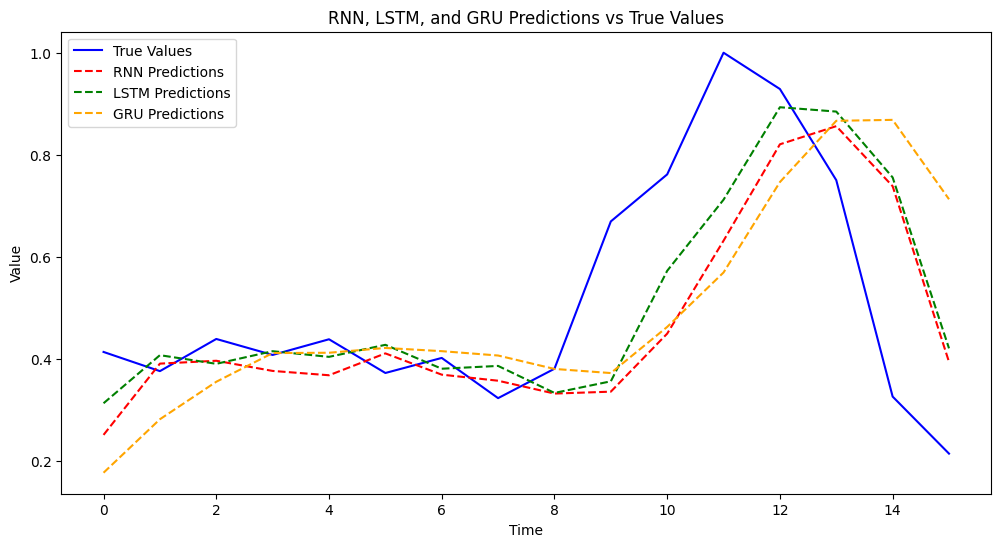

In [24]:
rnn_predictions = predict(rnn_model, X_test, batch_size=32)
lstm_predictions = predict(lstm_final_model, X_test, batch_size=32)
gru_predictions = predict(gru_final_model, X_test, batch_size=32)

# 将预测数据反归一化
rnn_predictions_org = denormalize_data(rnn_predictions, min_vals, max_vals)
lstm_predictions_org = denormalize_data(lstm_predictions, min_vals, max_vals)
gru_predictions_org = denormalize_data(gru_predictions, min_vals, max_vals)
true_org = denormalize_data(y_test, min_vals, max_vals)

plt.figure(figsize=(12, 6))
plt.plot(true_org, label='True Values', color='blue')
plt.plot(rnn_predictions_org, label='RNN Predictions', color='red', linestyle='--')
plt.plot(lstm_predictions_org, label='LSTM Predictions', color='green', linestyle='--')
plt.plot(gru_predictions_org, label='GRU Predictions', color='orange', linestyle='--')

plt.title('RNN, LSTM, and GRU Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()